# GAN's (Generical Adversarial networks)
* The following project is about creating a "generical adversarial network" using two convonutional neuronal networks which are compiting each other in order to generate a Data set
* the implementation is a DCGAN
* the generator which is the convolutional neuronal network in wich we generate the data
* the discriminator wich is the convolutional neuronal network in wich we will do binary classification (real vs fake)
* the main objective of GANs is create a model that can generate samples, given a bunch of samples from a particular distribution, and the GAN will give us new more samples from the same distribution, to generate this samples we will use a generator to have at the very end a discriminator that won't be able to indentify if the image is fake or not, and in that way the discriminator will give a probability of 0.5 to each image

## The Learning
* we provide a distribution of some data, the model will learn the distribution and it will give a good prediction
* Adversarial networks are focuses on the weakness of the system and spott those weaknesses to work on that
* the discriminator is a classifier (standar supervised-learning)
* the generator has random noise to generate images
* the min/max game consist on one of the two (generator and discriminator) wants the numbers to be high and the another wants the numbers to be low, the number is the error rate (loss function)
* the generator gets help by the gradient descent algorithm in which gradients are coming from the discriminator used to train the generator
* theoretically the generator will do images exactly to sample data, while the generator learns is doing a mapping space into the pictures, this is called the latent space

In [ ]:
#Libreries
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
#downloading the data set in which we will do the training
trainset= torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
classes = ("t-shirt","trousers","pullover","dress","coat","sandal","shirt","sneaker","bag", "ankle boot")


In [ ]:
#the dataset
#the dataset is small, it's load on memory, converted it to a tensor, then normalized the images in 255
import numpy as np

class Dataset(torch.utils.data.Dataset):
  def __init__(self, trainset):
    self.imgs = torch.tensor([np.array(i[0]).flatten() / 255. for i in trainset], dtype=torch.float, device=device)
    '''normalizing dataset'''
    self.imgs = self.imgs * 2. - 1.
    self.labels = torch.tensor([i[1] for i in trainset], dtype=torch.long, device=device)

  def __len__(self):
    return len(self.imgs)

  '''devuelve cada image cuando se las pida'''
  def __getitem__(self, ix):
    return self.imgs[ix], self.labels[ix]

train = Dataset(trainset)
len(train)
        

60000

In [ ]:
img, label = train[0]
img.shape, img.dtype, img.max(), img.min()

(torch.Size([784]), torch.float32, tensor(1.), tensor(-1.))

In [ ]:
#dataloader used to provide the images in batches to the neuronal network
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)

imgs, labels = next(iter(dataloader))
imgs.shape, labels.shape


(torch.Size([32, 784]), torch.Size([32]))

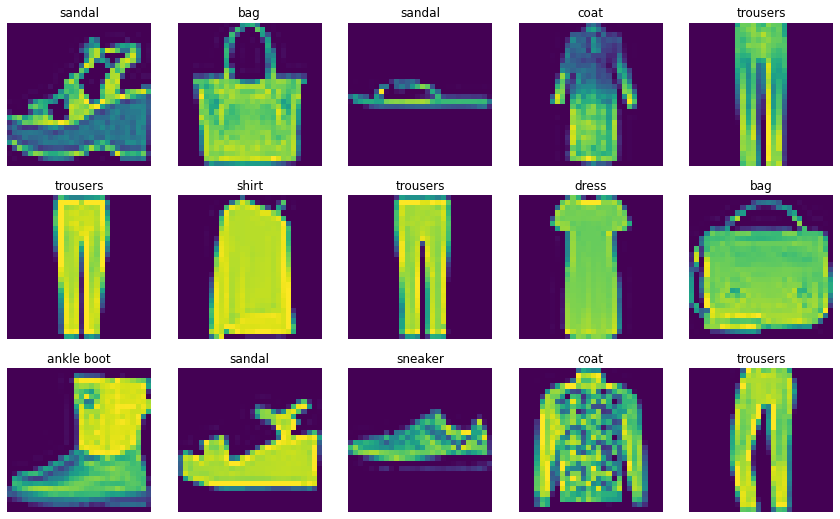

In [ ]:
import random 
import matplotlib.pyplot as plt

r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(train)-1)
        img, label = train[ix]
        plt.imshow(img.reshape(28,28).cpu())
        plt.axis('off')
        plt.title(classes[label.item()])
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

In [ ]:
#GENERATOR

class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = 100
        self.input = torch.nn.Sequential(
            torch.nn.Linear(self.input_size,7*7*128),
            torch.nn.BatchNorm1d(7*7*128),
        )
        #The architecture is a Conv
        self.main = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(128, 64, 4, stride =2, padding=1, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, bias=False),
            torch.nn.Tanh()
        )
    def forward(self,x):
        x = self.input(x)
        x = x.view(-1, 128, 7, 7)
        x = self.main(x)
        x = x.view(x.size(0), 28*28)
        return x
    

In [ ]:
#Instanciate of the Generator
generator = Generator()
output = generator(torch.randn(64, 100))
output.shape

torch.Size([64, 784])

In [ ]:
#DISCRIMINATOR
class Discriminator(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.main = torch.nn.Sequential(
        torch.nn.Conv2d(1, 64, 4, stride=2, padding=1, bias=False),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(True),
        torch.nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(True)
    )
    self.out = torch.nn.Sequential(
        torch.nn.Linear(128*7*7, 1),
        torch.nn.Sigmoid()
    )

  def forward(self, x):
    # waiting for inputs vector of 28*28
    x = x.view(x.size(0), 1, 28, 28)
    x = self.main(x)
    x = x.view(x.size(0), -1)
    x = self.out(x)
    return x

In [ ]:
discriminator = Discriminator()
output = discriminator(torch.randn(64, 28*28))
output.shape

torch.Size([64, 1])

In [ ]:
#FITTING THE MODEL (TRAINING)
from fastprogress import master_bar, progress_bar
def fit(g, d, dataloader, epochs=30, crit=None):
  g.to(device)
  d.to(device)

  g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
  d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)
  
  crit = torch.nn.BCEWithLogitsLoss() if crit == None else crit
  g_loss, d_loss = [], []
  mb = master_bar(range(1, epochs+1))
  hist = {'g_loss': [], 'd_loss': []}
  
  for epoch in mb:
    
    for X, y in progress_bar(dataloader, parent=mb):
      #phase 1
      #X, y = X.to(device), y.to(device)  
      #training the discriminator
      g.eval()
      d.train()
      #generate a batch of fake images
      noise = torch.randn((X.size(0), g.input_size)).to(device)
      genenerated_images = g(noise)
      d_input = torch.cat([genenerated_images, X.view(X.size(0), -1)])
      #gorund truth for the discriminator
      d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1,1).to(device)
      #--------------------------
      #optimization
      d_optimizer.zero_grad()
      d_output = d(d_input)
      d_l = crit(d_output, d_gt)
      d_l.backward()
      d_optimizer.step()
      d_loss.append(d_l.item())
      #------------------------------------

      #phase 2
      #training the generator
      g.train()
      d.eval()
      #generate a batch of fake images from the generator
      noise = torch.randn((X.size(0), g.input_size)).to(device)
      genenerated_images = g(noise)
      #output of the discriminator
      d_output = d(genenerated_images)
      #gorund truth for the generator
      g_gt = torch.ones(X.size(0)).view(-1,1).to(device)
      #--------------------------
      #optimization
      g_optimizer.zero_grad()
      g_l = crit(d_output, g_gt)
      g_l.backward()
      g_optimizer.step()
      g_loss.append(g_l.item())
      # logs

      #visual output lines of the training
      mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
    mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
    hist['g_loss'].append(np.mean(g_loss))    
    hist['d_loss'].append(np.mean(d_loss))
  return hist

In [ ]:
hist = fit(generator,discriminator,dataloader,crit=torch.nn.BCELoss())

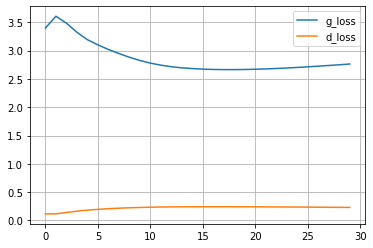

In [ ]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

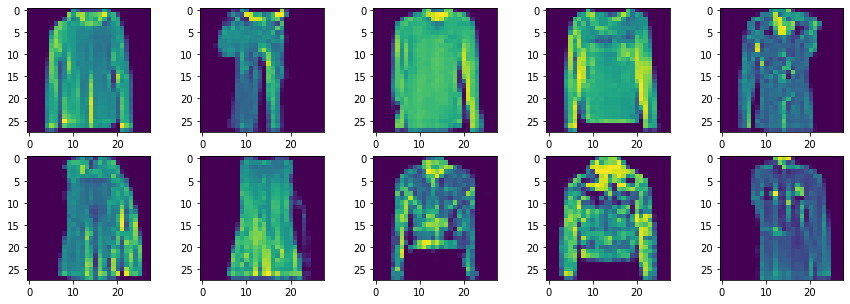

In [ ]:
#Generation part
generator.eval()
with torch.no_grad():
  noise = torch.randn((10, generator.input_size)).to(device)
  generated_images = generator(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = generated_images[i].view(28,28).cpu()
      _ax.imshow(img)
      i+=1
  plt.show()